# PaperCompanion1_II - Deterministic Models
Notebook to generate the second part of figure 1 of the paper, depicting the deterministic Models.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
# import own functions
from agent_game_sim import reward_matrix_for_two_player_PD
from agent_game_sim import generate_q_values
from agent_game_sim import get_individual_matrices

class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

class DeterministicBatchAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

        self.prob_vector_initial = np.exp(self.Q_values_initial / temperature) / np.sum(np.exp(self.Q_values_initial / temperature))
        self.prob_vector = self.prob_vector_initial

    def get_prob_vector(self):
        return self.prob_vector
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial
        self.prob_vector = self.prob_vector_initial

def deterministic_QL_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

def deterministic_batch_QL_step(agents, reward_matrices):
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    prob_vector_new_1 = ( prob_vector_agent_1 * np.exp(agent_1.learning_rate * (reward_matrix_A @ prob_vector_agent_2 - agent_1.temperature * np.log(prob_vector_agent_1))) ) / np.sum( prob_vector_agent_1 * np.exp(agent_1.learning_rate * (reward_matrix_A @ prob_vector_agent_2 - agent_1.temperature * np.log(prob_vector_agent_1)) ) )
    prob_vector_new_2 = ( prob_vector_agent_2 * np.exp(agent_2.learning_rate * (prob_vector_agent_1 @ reward_matrix_B - agent_2.temperature * np.log(prob_vector_agent_2))) ) / np.sum( prob_vector_agent_2 * np.exp(agent_2.learning_rate * (prob_vector_agent_1 @ reward_matrix_B - agent_2.temperature * np.log(prob_vector_agent_2)) ) )

    # update the Q-values
    agent_1.prob_vector = prob_vector_new_1
    agent_2.prob_vector = prob_vector_new_2

Plot deterministic dynamics for an initial probability pair (0.5, 0.48) and a discount factor of 0.8.

In [ ]:
reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function), 'Prisoner\'s Dilemma', 'Cooperation'

# parameters
num_players = 2
learning_rate = 0.01
discount_factor = 0.8 
temperature = 1
# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0
# define the initial Q-values
initial_probability_pair = (0.5, 0.48)
Q_values_initial_list = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]
# Calculate resulting initial probabilities. first value is for agent 1, second value is for agent 2
initial_probability_pair = [np.exp(Q_values_initial[0] / temperature) / np.sum(np.exp(Q_values_initial / temperature)) for Q_values_initial in Q_values_initial_list]
# set the number of time steps
num_time_steps = int(1e5)

# run deterministic Q-learning model
agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
for time_step in range(num_time_steps):
    deterministic_QL_step(agents, reward_matrices)

# run deterministic BATCH Q-learning model
agent_pair = [DeterministicBatchAgent, DeterministicBatchAgent]
initial_q_tables_deterministic_agents = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]
agents_batch = [agent_pair[i](Q_values_initial = initial_q_tables_deterministic_agents[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]
for t in range(num_time_steps):
    deterministic_batch_QL_step(agents_batch, reward_matrices)
# get the histories of probabilities to cooperate for each agent 
n = 1 # plot only every n-th time step to reduce the number of lines
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_78687/3176690188.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


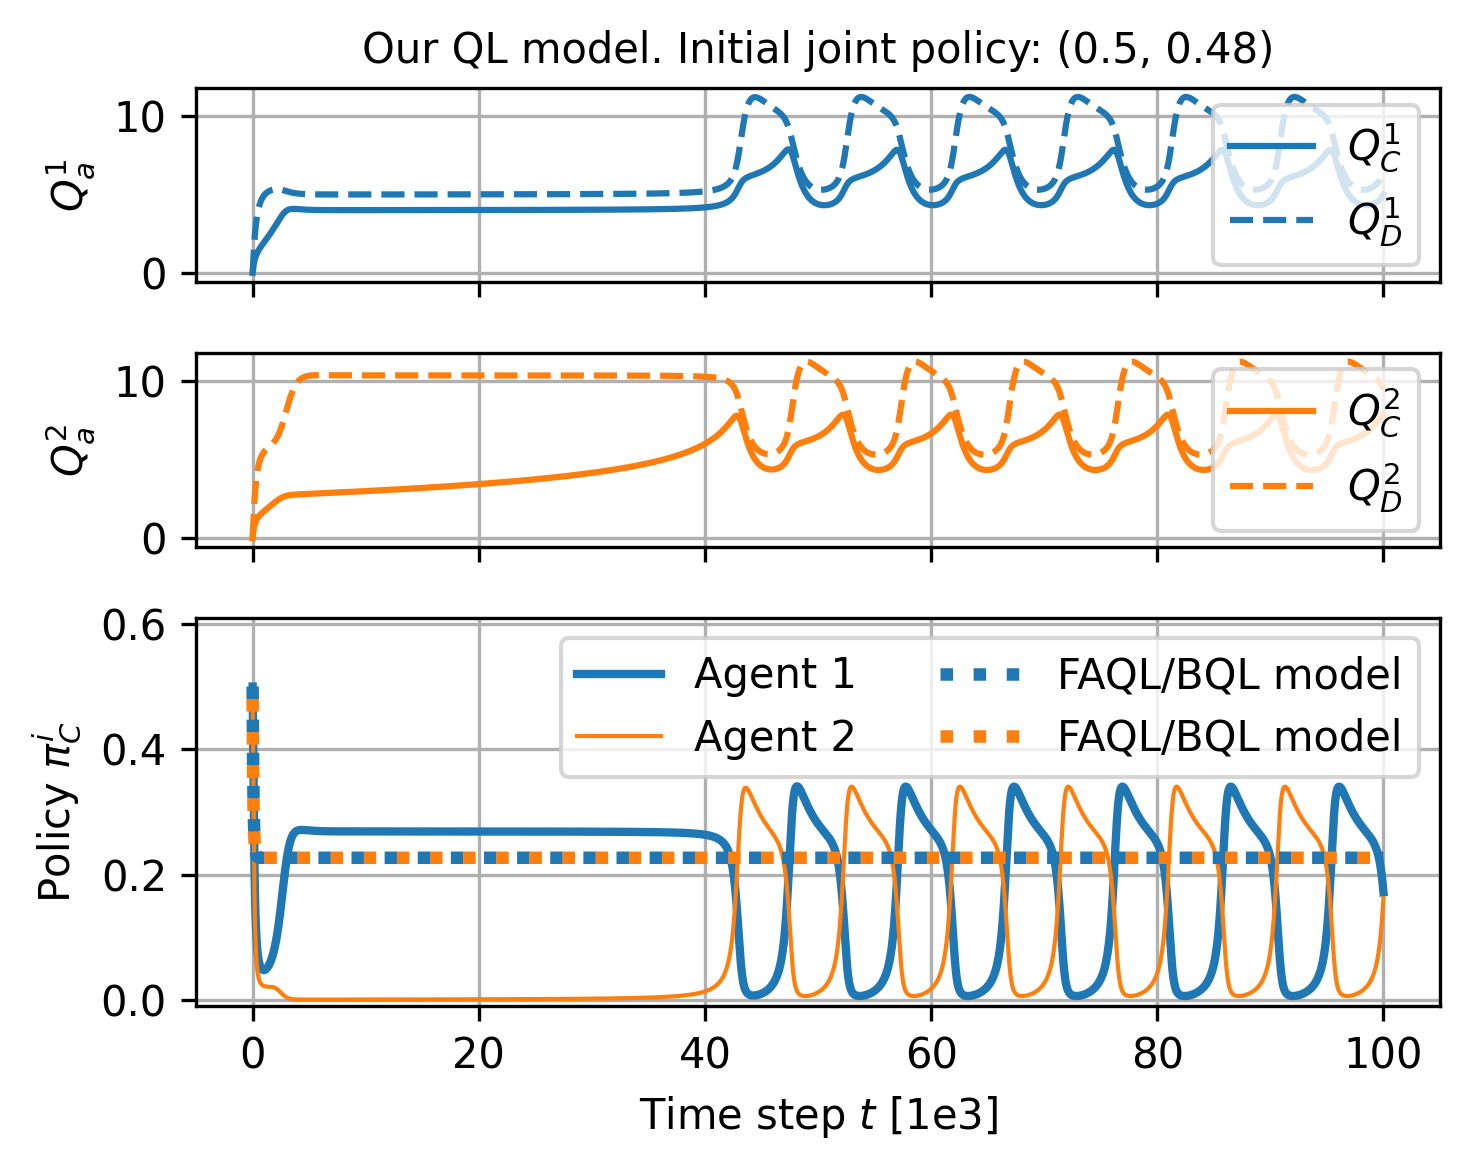

In [3]:
# Plotting parameters
directory_for_figures = 'PaperFigures' # directory for saving the figures
if not os.path.exists(directory_for_figures):
    os.makedirs(directory_for_figures)
figsize=(5, 4)
fontsize = None
dpi=300 # dpi for saving the figure
color1 = 'C0' # color blue for the first agent
color2 = 'C1' # color orange for the second agent
color_array = [color1, color2]
linestyle_array = ['-', '--']
linewidth_array = [2, 1]
fig, ax = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})

# plot Q-values over time for each agent seperate
for i, agent in enumerate(agents):
    color = color_array[i]
    ax[i].plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 0], label=f'$Q^{i+1}_C$', linestyle=linestyle_array[0], color=color)
    ax[i].plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 1], label=f'$Q^{i+1}_D$', linestyle=linestyle_array[1], color=color)
    # use scientific notation for the x-axis
    ax[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[i].set_ylabel(f'$Q^{i+1}_a$')
    ax[i].legend(loc="center right")
    ax[i].grid()

# identify which range is larger
y_range_0 = ax[0].get_ylim()
y_range_1 = ax[1].get_ylim()
# get the minimum and the maximum
y_range = [min(y_range_0[0], y_range_1[0]), max(y_range_0[1], y_range_1[1])]
for i in range(2):
    ax[i].set_ylim(y_range)
    
# plot deterministic QL dynamics in policy-space
for i, agent in enumerate(agents):
    ax[2].plot(np.arange(num_time_steps), np.array(agent.prob_vector_history)[:, 0], label=f'Agent {i+1}', linewidth=linewidth_array[i], color=color_array[i])

# plot deterministic BATCH QL dynamics in policy-space
for i, agent_batch in enumerate(agents_batch):
    ax[2].plot(np.arange(num_time_steps), np.array(agent_batch.prob_vector_history)[:, 0], label=f'FAQL/BQL model', linestyle=':', linewidth=3, color=color_array[i])

# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.0f}'
# Set the custom formatter for the x-axis
ax[2].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set labels
ax[2].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
ax[2].legend(loc="upper right", ncol=2)
ax[2].grid()

# fix the y-axis to the range
ax[2].set_ylim(-0.01, 0.61)
if initial_probability_pair == (0.9, 0.7):
    ax[2].set_ylim(-0.01, 1.1)
    ax[2].set_yticks(np.arange(0, 1.2, 0.2))

# title
ax[0].set_title(f'Our QL model. Initial joint policy: ({initial_probability_pair[0]:.1f}, {initial_probability_pair[1]:.2f})', fontsize=fontsize)
# save the figure
fig.tight_layout()
fig.savefig(os.path.join(directory_for_figures, f'Fig1_MODEL_TimeEvolution_p_initial_({initial_probability_pair[0]:.2f},{initial_probability_pair[1]:.2f})_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf'), dpi=dpi, bbox_inches='tight')
fig.show()

Plot deterministic dynamics for an initial probability pair (0.9, 0.7) and a discount factor of 0.8.

In [ ]:
# set parameters
temperature = 1
learning_rate = 0.01
discount_factor = 0.8
# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0
# define the initial Q-values
initial_probability_pair = (0.9, 0.7)
Q_values_initial_list = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]
# set the number of time steps
num_time_steps = int(2.05e6)

# run deterministic Q-learning model
agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
for time_step in range(num_time_steps):
    deterministic_QL_step(agents, reward_matrices)

# run deterministic BATCH Q-learning model
num_time_steps_for_batch_QL = int(3e3)
agents_batch = [DeterministicBatchAgent(Q_values_initial = Q_values_initial_list[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]
for t in range(num_time_steps_for_batch_QL):
    deterministic_batch_QL_step(agents_batch, reward_matrices)
# get the histories of probabilities to cooperate for each agent 
n = 1 # get only every n-th time step to reduce the number of lines to plot
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_78687/1859322026.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


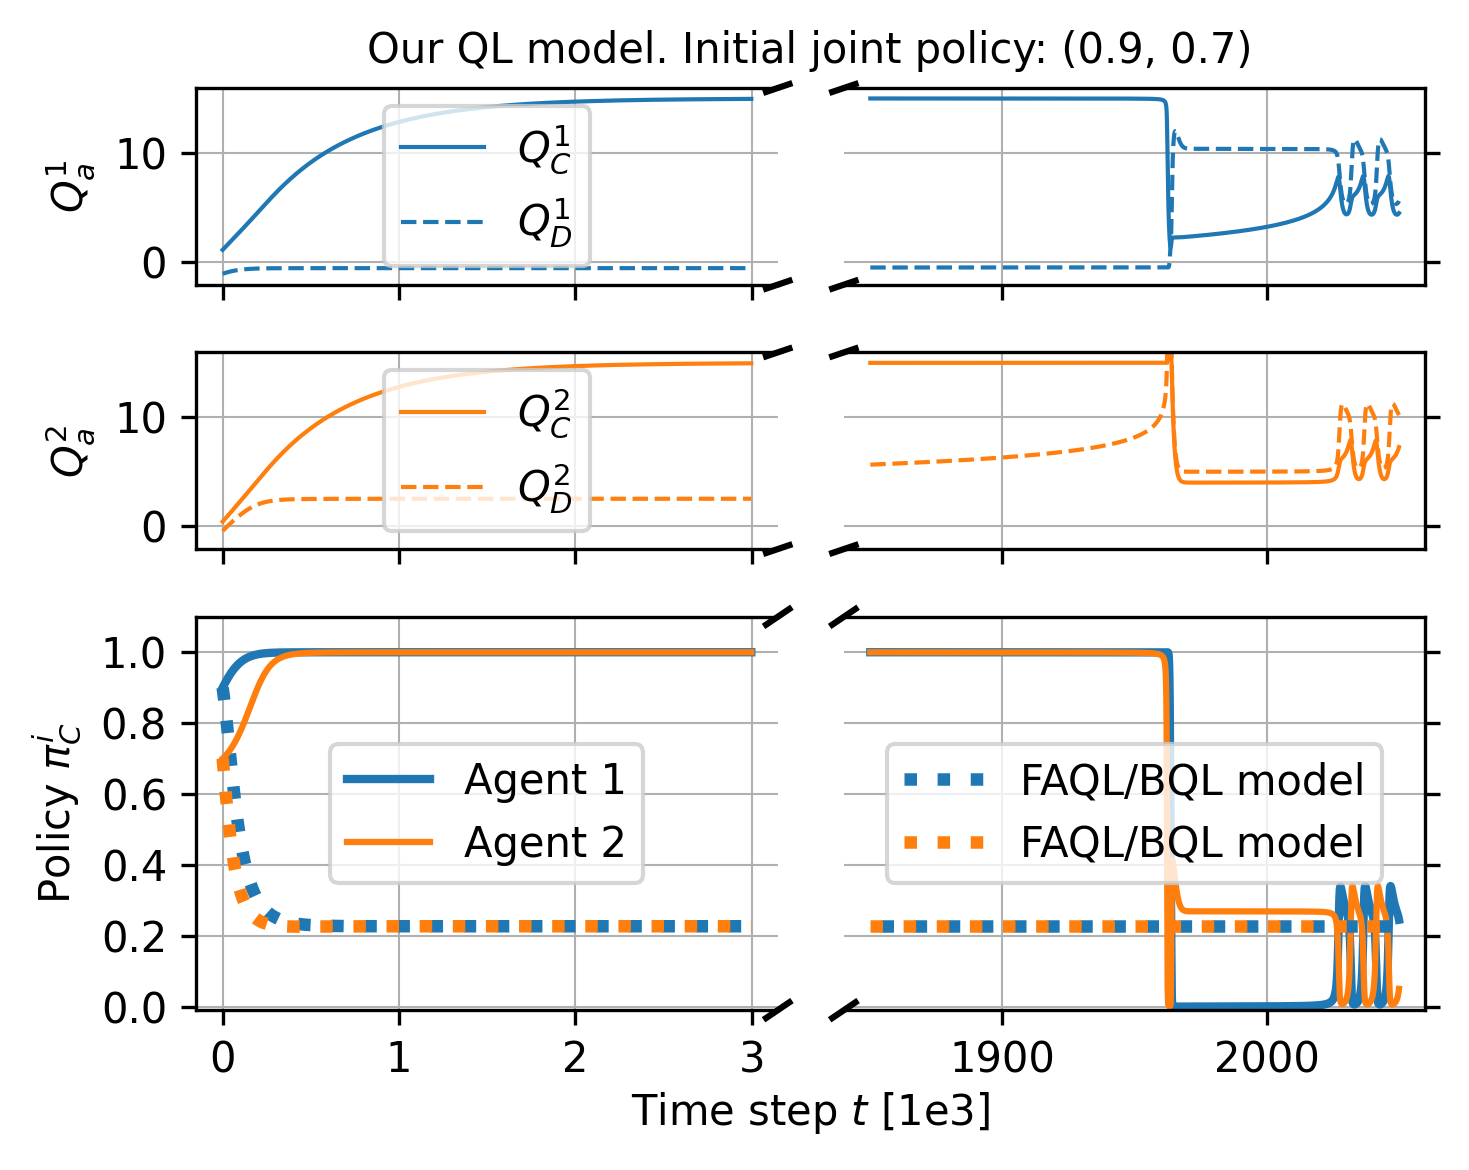

In [5]:
# Plotting parameters
fig, ax = plt.subplots(3, 2, figsize=figsize, dpi=dpi, gridspec_kw={'height_ratios': [1, 1, 2]}, sharex='col', sharey='row')

x_range_1 = np.arange(0, int(3e3)-1)
x_range_2 = np.arange(int(1.85e6), num_time_steps-1)
loc="center" # change the location of the legend for the (0.9, 0.7) case where gamma = 0.8
linewidth  = 3

# ----------------- LEFT SIDE: first range ----------------- 
# FIGURE A: plot Q-values over time
for i, agent in enumerate(agents):
    q_values_C_range_1 = np.array(agent.Q_values_history)[x_range_1, 0]
    q_values_D_range_1 = np.array(agent.Q_values_history)[x_range_1, 1]
    ax[i][0].plot(x_range_1, q_values_C_range_1, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][0].plot(x_range_1, q_values_D_range_1, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i][0].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][0].grid(linestyle='-', linewidth=0.5)
    ax[i][0].legend(loc=loc, fontsize=fontsize)

# calculate the range of the y-axis
min_agent_1 = np.min(np.array(agents[0].Q_values_history)[x_range_1])
max_agent_1 = np.max(np.array(agents[0].Q_values_history)[x_range_1])
min_agent_2 = np.min(np.array(agents[1].Q_values_history)[x_range_1])
max_agent_2 = np.max(np.array(agents[1].Q_values_history)[x_range_1])
y_range = [min( min_agent_1, min_agent_2)-1, max( max_agent_1, max_agent_2)+1]
for i in range(2):
    ax[i][0].set_ylim(y_range)

# FIGURE B: plot probabilities over time
handle1 = ax[2][0].plot(x_range_1, np.array(agents[0].prob_vector_history)[x_range_1, 0], label=f'Agent 1', color=color1, zorder=10, linewidth=2)
handle2 = ax[2][0].plot(x_range_1, np.array(agents[1].prob_vector_history)[x_range_1, 0], label=f'Agent 2', color=color2, zorder=10, linestyle='-')
# plot deterministic batch probabilities over time
handle3 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_1_list)[x_range_1], color=color1, zorder=5, linewidth=linewidth, linestyle=':')
handle4 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_2_list)[x_range_1], color=color2, zorder=5, linewidth=linewidth, linestyle=':')
# set labels
ax[2][0].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][0].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.0f}'
# Set the custom formatter for the x-axis
ax[2][0].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set the ticks of the y-axis to be in steps of 0.2
ax[2][0].set_yticks(np.arange(0, 1.2, 0.2))
ax[2][0].legend(loc="center", fontsize=fontsize)
ax[2][0].grid(linestyle='-', linewidth=0.5)

# ----------------- RIGHT SIDE: second range ----------------- 
# FIGURE A: plot Q-values over time
for i, agent in enumerate(agents):
    q_values_C_range_2 = np.array(agent.Q_values_history)[x_range_2, 0]
    q_values_D_range_2 = np.array(agent.Q_values_history)[x_range_2, 1]
    ax[i][1].plot(x_range_2, q_values_C_range_2, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][1].plot(x_range_2, q_values_D_range_2, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i][1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][1].grid(linestyle='-', linewidth=0.5)
# ensure that the y-axis is the same as on the left side
ax[0][1].set_ylim(y_range)
ax[1][1].set_ylim(y_range)

# FIGURE B: plot probabilities over time
ax[2][1].plot(x_range_2, np.array(agents[0].prob_vector_history)[x_range_2, 0], color=color1, linewidth=2)
ax[2][1].plot(x_range_2, np.array(agents[1].prob_vector_history)[x_range_2, 0], color=color2, linestyle='-')
# plot deterministic batch probabilities over time
ax[2][1].plot([min(x_range_2)+int(4e3), max(x_range_2)], [np.array(prob_coop_of_agent_batch_1_list)[-1], np.array(prob_coop_of_agent_batch_1_list)[-1]], color=color1, linestyle = ':', linewidth=linewidth, label=f'FAQL/BQL model')
ax[2][1].plot([min(x_range_2), max(x_range_2)], [np.array(prob_coop_of_agent_batch_2_list)[-1], np.array(prob_coop_of_agent_batch_2_list)[-1]], color=color2, linestyle = ':',  linewidth=linewidth, label=f'FAQL/BQL model')
# set labels
ax[2][1].set_xlabel(' ', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][1].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.0f}'
# Set the custom formatter for the x-axis
ax[2][1].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
ax[2][1].legend(loc="center", fontsize=fontsize)
ax[2][1].grid(linestyle='-', linewidth=0.5)

for i in range(3):
    # Hide the spines between the subplots
    ax[i][0].spines['right'].set_visible(False)
    ax[i][1].spines['left'].set_visible(False)
    ax[i][0].yaxis.tick_left()
    ax[i][1].yaxis.tick_right()

    # Add diagonal lines to indicate the break
    d = .02  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax[i][0].transAxes, color='k', clip_on=False)
    ax[i][0].plot((1-d, 1+d), (-d, +d), **kwargs)
    ax[i][0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    kwargs.update(transform=ax[i][1].transAxes)  # switch to the right axes
    ax[i][1].plot((-d, +d), (-d, +d), **kwargs)
    ax[i][1].plot((-d, +d), (1-d, 1+d), **kwargs)

# Add a common x-axis label
fig.text(0.55, 0.05, 'Time step $t$ [1e3]', ha='center')

# title
ax[0][0].set_title(f' ', fontsize=fontsize)
fig.text(0.55, 0.935, f'Our QL model. Initial joint policy: {initial_probability_pair}', fontsize=fontsize, ha='center')

# save the figure
fig.tight_layout()
fig.savefig(os.path.join(directory_for_figures, f'Fig1_MODEL_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf'), dpi=dpi, bbox_inches='tight')
fig.show()